In [1]:


import struct
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:


def decode_labels(file):

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int)


def decode_images(file):

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * (num_images * cols * rows), binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)


def relu(x):
    return x * (x > 0)

def derelu(x):
    return (x > 0).astype(np.float32)

def sigmoid(x):
    output = 1 / (1 + np.exp(-x))
    return np.clip(output, a_min=1e-4, a_max=1-1e-4)


def desigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def cross_entropy(target, predict):
    return np.sum(target * np.log(predict) + (1 - target) * np.log(1 - predict))


def softmax(predict):
    exp_predict = np.exp(predict)
    total = np.sum(exp_predict, axis=1, keepdims=True)
    return exp_predict / total


def softmaxLoss(target, predict):
    return np.sum(target * np.log(predict))


def one_hot(t, num_classes):
    
    rows = t.shape[0]
    output = np.zeros((rows, num_classes))
    
    for row in range(rows):
        label = t[row, 0]
        output[row, label] = 1
    return output

def norm_image(image):
    return (image / 255 - 0.5).astype(np.float32)

def augment_image(image, images):
    index = random.randint(0, images.shape[0] - 1)
    alpha = random.random() * 0.2 + 0.8
    beta = 1 - alpha
    return image * alpha + images[index] * beta


def label_smoothing(inputs, epsilon=0.3):
    num_classes = inputs.shape[-1]
    return (1 - epsilon) * inputs + epsilon / num_classes


In [3]:
train_images = decode_images("dataset/train-images-idx3-ubyte")
train_labels = decode_labels("dataset/train-labels-idx1-ubyte")
test_images = decode_images("dataset/t10k-images-idx3-ubyte")
test_labels = decode_labels("dataset/t10k-labels-idx1-ubyte")

In [14]:

batch_size = 512
num_hidden = 256
num_output = 10
num_train_images = train_images.shape[0]
num_property = train_images.shape[1]
learning_rate = 0.1


In [15]:
w_IH = np.random.normal(0, 1, size=(num_property, num_hidden))
#w_IH = np.zeros((num_property, num_hidden)) 
b_IH = np.zeros((1, num_hidden))

w_HO = np.random.normal(0, 1, size=(num_hidden, num_output))
#w_HO = np.zeros((num_hidden, num_output))
b_HO = np.zeros((1, num_output))

In [16]:
batch_per_epoch = math.ceil(num_train_images / batch_size)
train_epochs = 100

In [17]:
lr_schedule = {
    0:  1e-1,
    50: 1e-2,
    80: 1e-3,
    90: 1e-4
}

In [18]:
#### # 构建索引，0，1，2，3......num_train_images-1
all_train_image_indexs = list(range(num_train_images))

for epoch_index in range(train_epochs):
    
    if epoch_index in lr_schedule:
        learning_rate = lr_schedule[epoch_index]
    
    # 打乱索引
    random.shuffle(all_train_image_indexs)
    
    for batch_index in range(batch_per_epoch):
        
        index_begin = batch_index * batch_size
        index_end = min(index_begin + batch_size, num_train_images)
        
        # 选择一个批次的索引
        select_indexs = all_train_image_indexs[index_begin:index_end]
        
        # 预处理、归一化数据
        train_batch_images = norm_image(train_images[select_indexs])
        train_batch_labels = train_labels[select_indexs]
        
        if epoch_index < 90:
            if random.random() < 0.1:
                train_batch_labels[random.randint(0, len(train_batch_labels) - 1)] = random.randint(0, 9)
        
        #for sample_index in range(train_batch_images.shape[0]):
        #    train_batch_images[sample_index] = augment_image(train_batch_images[sample_index], train_batch_images)
        
        # 转换label到one hot
        train_batch_target = one_hot(train_batch_labels, num_classes = num_output)
        
        
        #  bp  forward
        #  ->  input to hidden
        hidden = np.matmul(train_batch_images, w_IH) + b_IH
        hidden_act = sigmoid(hidden)
        
        #  ->  hidden to output
        output = np.matmul(hidden_act, w_HO) + b_HO
        output_trans = softmax(output)
        
        # compute loss
        loss = -softmaxLoss(train_batch_target, output_trans) / batch_size
        
        # bp backward
        loss_2_softmax = output_trans
        loss_2_softmax[train_batch_target.astype(np.bool)] -= 1
        delta_loss_2_output = (1 / batch_size) * loss_2_softmax
        
        # 隐层求导
        delta_loss_2_b_HO = delta_loss_2_output
        delta_loss_2_w_HO = np.matmul(delta_loss_2_output.T, hidden_act).T
        
        # 对hidden求导
        delta_loss_2_hidden = np.matmul(delta_loss_2_output, w_HO.T) * desigmoid(hidden)
        
        # 对输入层求导
        delta_loss_2_b_IH = delta_loss_2_hidden
        delta_loss_2_w_IH = np.matmul(delta_loss_2_hidden.T, train_batch_images).T
        
        # 参数更新
        w_IH = w_IH - learning_rate * delta_loss_2_w_IH
        b_IH = b_IH - learning_rate * np.sum(delta_loss_2_b_IH, axis=0, keepdims=True)
        
        w_HO = w_HO - learning_rate * delta_loss_2_w_HO
        b_HO = b_HO - learning_rate * np.sum(delta_loss_2_b_HO, axis=0, keepdims=True)
        
    print("Epoch: {}, Loss: {:.2f}, LR: {}".format(epoch_index, loss, learning_rate))


Epoch: 0, Loss: 0.42, LR: 0.1
Epoch: 1, Loss: 0.30, LR: 0.1
Epoch: 2, Loss: 0.24, LR: 0.1
Epoch: 3, Loss: 0.18, LR: 0.1
Epoch: 4, Loss: 0.13, LR: 0.1
Epoch: 5, Loss: 0.17, LR: 0.1
Epoch: 6, Loss: 0.15, LR: 0.1
Epoch: 7, Loss: 0.22, LR: 0.1
Epoch: 8, Loss: 0.15, LR: 0.1
Epoch: 9, Loss: 0.17, LR: 0.1
Epoch: 10, Loss: 0.11, LR: 0.1
Epoch: 11, Loss: 0.13, LR: 0.1
Epoch: 12, Loss: 0.16, LR: 0.1
Epoch: 13, Loss: 0.08, LR: 0.1
Epoch: 14, Loss: 0.14, LR: 0.1
Epoch: 15, Loss: 0.11, LR: 0.1
Epoch: 16, Loss: 0.10, LR: 0.1
Epoch: 17, Loss: 0.10, LR: 0.1
Epoch: 18, Loss: 0.12, LR: 0.1
Epoch: 19, Loss: 0.16, LR: 0.1
Epoch: 20, Loss: 0.09, LR: 0.1
Epoch: 21, Loss: 0.11, LR: 0.1
Epoch: 22, Loss: 0.13, LR: 0.1
Epoch: 23, Loss: 0.06, LR: 0.1
Epoch: 24, Loss: 0.08, LR: 0.1
Epoch: 25, Loss: 0.04, LR: 0.1
Epoch: 26, Loss: 0.11, LR: 0.1
Epoch: 27, Loss: 0.08, LR: 0.1
Epoch: 28, Loss: 0.04, LR: 0.1
Epoch: 29, Loss: 0.05, LR: 0.1
Epoch: 30, Loss: 0.10, LR: 0.1
Epoch: 31, Loss: 0.08, LR: 0.1
Epoch: 32, Loss: 0

array([9])

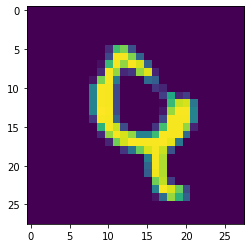

In [19]:
plt.imshow(train_batch_images[2].reshape(28, 28))
train_batch_labels[2]

(<matplotlib.image.AxesImage at 0x11c21ebe0>, array([9]))

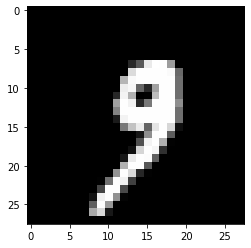

In [20]:
image_index = 1000
t_image = test_images[image_index]
plt.imshow(t_image.reshape(28, 28), cmap="gray"), test_labels[image_index]

In [23]:
hidden = np.matmul(norm_image(test_images), w_IH) + b_IH
hidden_act = sigmoid(hidden)
output = np.matmul(hidden_act, w_HO) + b_HO
output = softmax(output)

all_predict_result = np.argmax(output, axis=1).reshape(-1, 1)
#test_labels
print("Image predict label: {}".format(all_predict_result))

Image predict label: [[7]
 [2]
 [1]
 ...
 [4]
 [8]
 [6]]


In [24]:
accuracy = np.sum(test_labels == all_predict_result) / test_labels.shape[0] * 100
print("train accuracy: {:.2f} %".format(accuracy))

train accuracy: 89.72 %


In [337]:
(100,)

(100,)

In [338]:
a = np.array([0.1, 0.8, -0.1, -0.5, 0])

In [341]:
relu(a)

array([ 0.1,  0.8, -0. , -0. ,  0. ])

In [344]:
derelu(a)

array([1., 1., 0., 0., 0.], dtype=float32)

In [367]:
np.clip(np.array([1, 2, 3, -1, -2, -3]), a_min=-2, a_max=2)

array([ 1,  2,  2, -1, -2, -2])

In [8]:
a = [1, 2, 3, 2]

In [9]:
softmax(a)

array([0.07232949, 0.19661193, 0.53444665, 0.19661193])

In [25]:
train_batch_labels[:, 0].shape

(512,)

In [33]:
output_trans.shape

(512, 10)

In [40]:
output_trans[train_batch_labels].shape

(512, 1, 10)

In [41]:
a = np.array([[1, 2, 3],
             [4, 5, 6]])

In [49]:
b = np.array([[0, 1, 0],
             [0, 0, 1]])

In [53]:
a[b.astype(np.bool)]

array([2, 6])

In [55]:
output_trans[train_batch_target.astype(np.bool)].shape

(512,)

In [56]:
delta_loss_2_b_HO.shape

(512, 10)

In [62]:
(np.log(output_trans * train_batch_target) * train_batch_target).shape

(512, 10)

In [78]:
log_p = np.log(output_trans * train_batch_target)
log_p[~train_batch_target.astype(np.bool)] = 0

/Users/datav/projects/Lesson/1.bp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [79]:
log_p

array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , -426.91773028],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , -379.58645086],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        -735.6640592 ,    0.        ]])

In [274]:
a = np.array([[1, 2, 3],
              [4, 6, 7]])

In [275]:
softmax(a)

array([[0.00171516, 0.0046623 , 0.01267344],
       [0.03444998, 0.25455282, 0.6919463 ]])

In [276]:
exp_predict = np.exp(a)
total = np.sum(exp_predict, axis=1, keepdims=True)
exp_predict / total

array([[0.09003057, 0.24472847, 0.66524096],
       [0.03511903, 0.25949646, 0.70538451]])

In [295]:
help(np.select)

Help on function select in module numpy:

select(condlist, choicelist, default=0)
    Return an array drawn from elements in choicelist, depending on conditions.
    
    Parameters
    ----------
    condlist : list of bool ndarrays
        The list of conditions which determine from which array in `choicelist`
        the output elements are taken. When multiple conditions are satisfied,
        the first one encountered in `condlist` is used.
    choicelist : list of ndarrays
        The list of arrays from which the output elements are taken. It has
        to be of the same length as `condlist`.
    default : scalar, optional
        The element inserted in `output` when all conditions evaluate to False.
    
    Returns
    -------
    output : ndarray
        The output at position m is the m-th element of the array in
        `choicelist` where the m-th element of the corresponding array in
        `condlist` is True.
    
    See Also
    --------
    where : Return elements f

In [296]:
help(random.randint)

Help on method randint in module random:

randint(a, b) method of random.Random instance
    Return random integer in range [a, b], including both end points.



In [28]:
a = np.array([0, 0, 0, 1])
label_smoothing(a)

array([0.075, 0.075, 0.075, 0.775])